In [ ]:
pip install EMD-signal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.3/82.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.3 MB/s eta 0:00:00


<ipython-input-2-1189fcbcef77>:38: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  traffic_series = pd.Series(traffic, index=pd.date_range("2025-01-01", periods=duration, freq="T"))


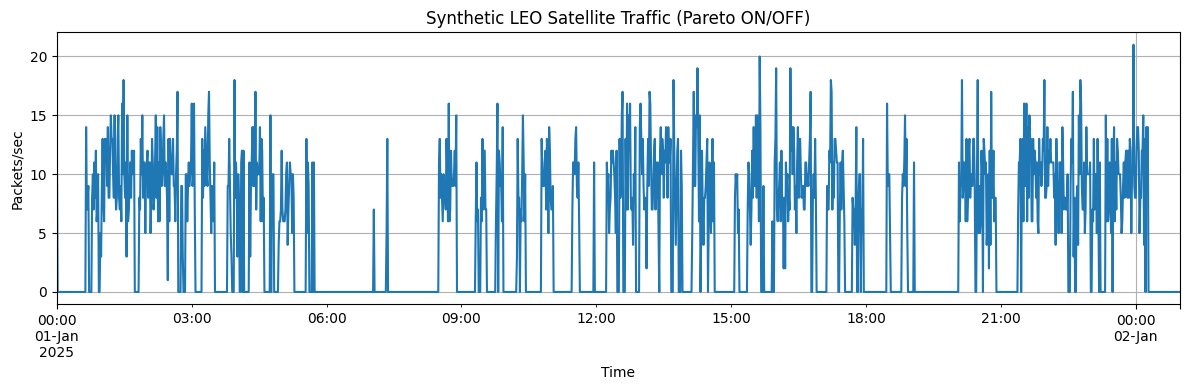

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
duration = 1500  # total time units (minutes)
alpha_on = 1.5   # shape parameter for ON duration
alpha_off = 1.3  # shape parameter for OFF duration
scale_on = 5     # scaling ON durations (in minutes)
scale_off = 3    # scaling OFF durations
packet_rate = 10  # average packets per second during ON

# Generate ON/OFF traffic
traffic = []
time = 0

while time < duration:
    on_duration = int(np.random.pareto(alpha_on) * scale_on)
    off_duration = int(np.random.pareto(alpha_off) * scale_off)

    # Limit to avoid exceeding the duration
    on_duration = min(on_duration, duration - time)
    off_duration = min(off_duration, duration - time - on_duration)

    # Simulate bursty Poisson traffic during ON period
    traffic.extend(np.random.poisson(packet_rate, size=on_duration))
    time += on_duration

    # Silence during OFF period
    traffic.extend([0] * off_duration)
    time += off_duration

# Create a time series
traffic = traffic[:duration]
traffic_series = pd.Series(traffic, index=pd.date_range("2025-01-01", periods=duration, freq="T"))

# Plot the traffic
traffic_series.plot(title="Synthetic LEO Satellite Traffic (Pareto ON/OFF)", figsize=(12, 4))
plt.ylabel("Packets/sec")
plt.xlabel("Time")
plt.grid(True)
plt.tight_layout()
plt.show()


Number of IMFs extracted: 8


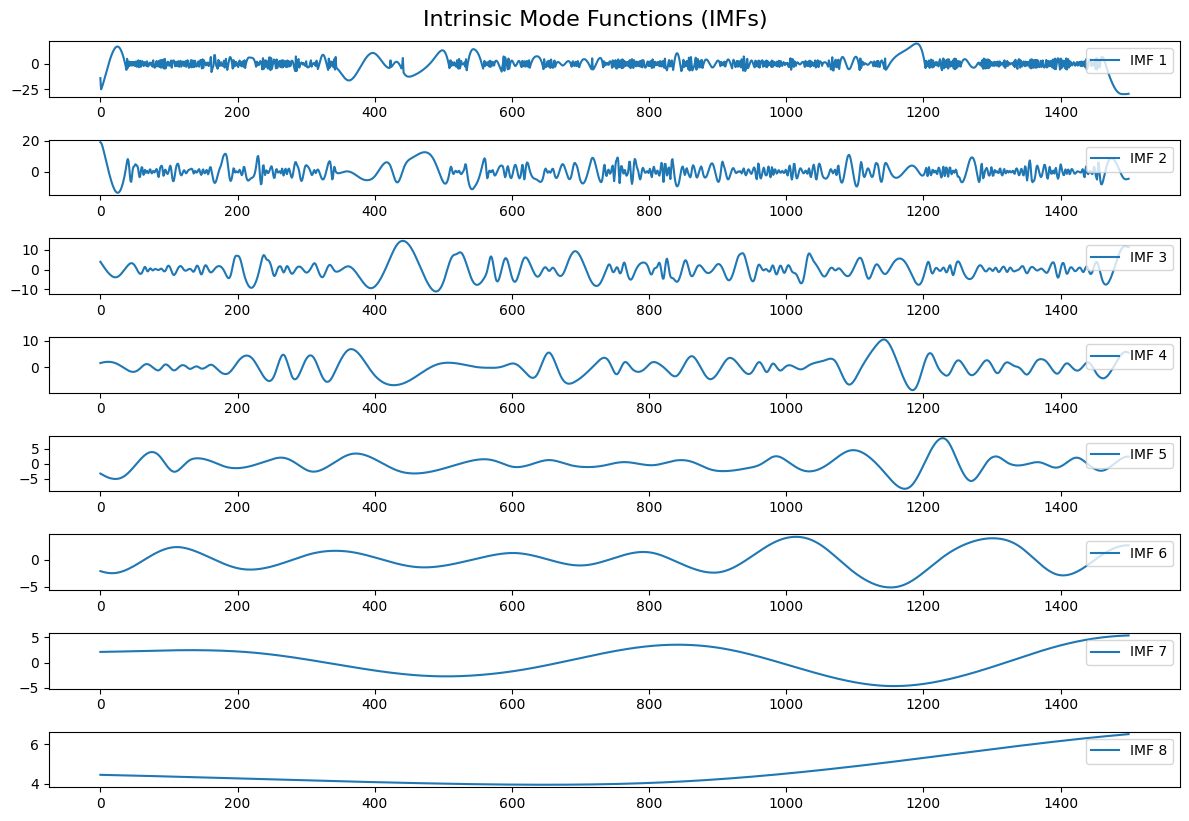

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Parameters
duration = 1500  # total time units (minutes)
alpha_on = 1.5   # shape parameter for ON duration
alpha_off = 1.3  # shape parameter for OFF duration
scale_on = 5     # scaling ON durations (in minutes)
scale_off = 3    # scaling OFF durations
packet_rate = 10  # average packets per second during ON

# Generate ON/OFF traffic
traffic = []
time = 0

while time < duration:
    on_duration = int(np.random.pareto(alpha_on) * scale_on)
    off_duration = int(np.random.pareto(alpha_off) * scale_off)

    # Limit to avoid exceeding the duration
    on_duration = min(on_duration, duration - time)
    off_duration = min(off_duration, duration - time - on_duration)

    # Simulate bursty Poisson traffic during ON period
    traffic.extend(np.random.poisson(packet_rate, size=on_duration))
    time += on_duration

    # Silence during OFF period
    traffic.extend([0] * off_duration)
    time += off_duration

# Create a time series
traffic = traffic[:duration]
traffic_series = pd.Series(traffic, index=pd.date_range("2025-01-01", periods=duration, freq="T"))

# Plot the traffic
traffic_series.plot(title="Synthetic LEO Satellite Traffic (Pareto ON/OFF)", figsize=(12, 4))
plt.ylabel("Packets/sec")
plt.xlabel("Time")
plt.grid(True)
plt.tight_layout()
plt.show()

from PyEMD import EMD
import matplotlib.pyplot as plt
import numpy as np

# Extract the raw values from the series
signal = traffic_series.values

# Initialize EMD and extract IMFs
emd = EMD()
imfs = emd(signal)

# Display number of IMFs
print(f"Number of IMFs extracted: {len(imfs)}")

# Plot IMFs
plt.figure(figsize=(12, 8))
for i, imf in enumerate(imfs):
    plt.subplot(len(imfs), 1, i + 1)
    plt.plot(imf, label=f"IMF {i+1}")
    plt.legend(loc="upper right")
    plt.tight_layout()
plt.suptitle("Intrinsic Mode Functions (IMFs)", fontsize=16, y=1.02)
plt.show()
from statsmodels.tsa.arima.model import ARIMA

# How many time steps to forecast
n_forecast = 200
imf_forecasts = []

# Fit ARIMA to each IMF and forecast
for idx, imf in enumerate(imfs):
    try:
        model = ARIMA(imf[:-n_forecast], order=(4,0,2))  # You can tune this
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=n_forecast)
        imf_forecasts.append(forecast)
    except Exception as e:
        print(f"Error fitting IMF {idx+1}: {e}")
        imf_forecasts.append(np.zeros(n_forecast))  # fallback to 0 if failed
# Reconstruct the forecasted linear signal by summing all IMF forecasts
linear_forecast = np.sum(imf_forecasts, axis=0)

# Plot the linear forecast vs actual traffic
actual_future = signal[-n_forecast:]

plt.figure(figsize=(12, 4))
plt.plot(actual_future, label='Actual Traffic')
plt.plot(linear_forecast, label='Linear Forecast (ARIMA on IMFs)', linestyle='--')
plt.title("ARIMA Forecast from EMD-Decomposed IMFs")
plt.xlabel("Time (minutes)")
plt.ylabel("Packets/sec")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Get the actual traffic for the forecasted range
actual = signal[-n_forecast:]

# Compute residual = actual - linear forecast
residual = actual - linear_forecast

# Plot residuals
plt.figure(figsize=(12, 3))
plt.plot(residual, label='Residuals (Non-linear Component)', color='orange')
plt.title("Residual Between Actual Traffic and Linear ARIMA Forecast")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Prepare input-output pairs for supervised learning
X = []
y = []

window_size = 5  # how many previous residual points to use
for i in range(len(residual) - window_size):
    X.append(residual[i:i+window_size])
    y.append(residual[i+window_size])

X = np.array(X)
y = np.array(y)

# Normalize inputs
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (use all for training here since it's just residuals)
model_bpnn = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=1000, random_state=42)
model_bpnn.fit(X_scaled, y)

# Predict residuals
predicted_residuals = model_bpnn.predict(X_scaled)

# Pad to match forecast length
bpnn_forecast = np.concatenate([residual[:window_size], predicted_residuals])
bpnn_forecast = bpnn_forecast[:n_forecast]

# Final forecast = linear part (ARIMA on IMFs) + non-linear part (BPNN on residuals)
final_forecast = linear_forecast + bpnn_forecast

# Plot everything
plt.figure(figsize=(12, 4))
plt.plot(actual, label='Actual Traffic')
plt.plot(linear_forecast, label='Linear (ARIMA only)', linestyle='--')
plt.plot(final_forecast, label='Hybrid Forecast (ARIMA + BPNN)', linestyle='-.')
plt.title("Final Forecast: ARIMA + BPNN on Residuals")
plt.xlabel("Time")
plt.ylabel("Packets/sec")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate
mse = mean_squared_error(actual, final_forecast)
print(f"Hybrid Forecast MSE: {mse:.4f}")


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# How many time steps to forecast
n_forecast = 200
imf_forecasts = []

# Fit ARIMA to each IMF and forecast
for idx, imf in enumerate(imfs):
    try:
        model = ARIMA(imf[:-n_forecast], order=(4,0,2))  # You can tune this
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=n_forecast)
        imf_forecasts.append(forecast)
    except Exception as e:
        print(f"Error fitting IMF {idx+1}: {e}")
        imf_forecasts.append(np.zeros(n_forecast))  # fallback to 0 if failed


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: Conver

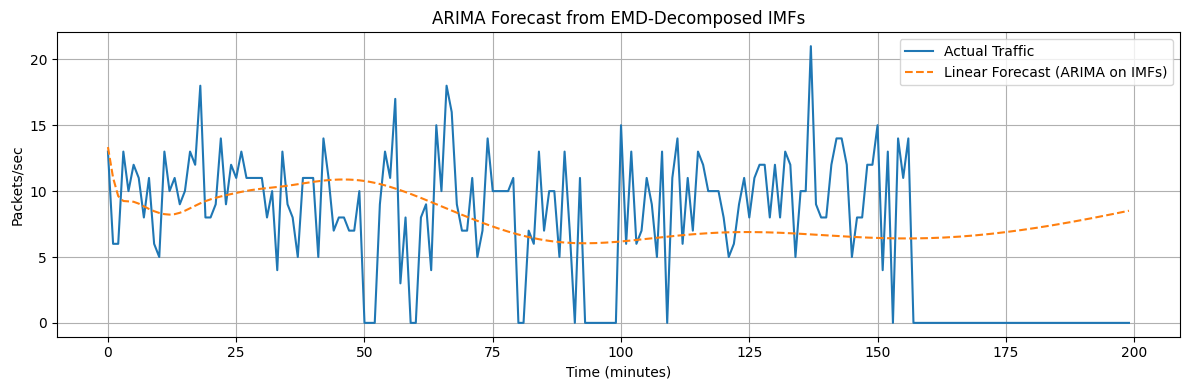

In [ ]:
# Reconstruct the forecasted linear signal by summing all IMF forecasts
linear_forecast = np.sum(imf_forecasts, axis=0)

# Plot the linear forecast vs actual traffic
actual_future = signal[-n_forecast:]

plt.figure(figsize=(12, 4))
plt.plot(actual_future, label='Actual Traffic')
plt.plot(linear_forecast, label='Linear Forecast (ARIMA on IMFs)', linestyle='--')
plt.title("ARIMA Forecast from EMD-Decomposed IMFs")
plt.xlabel("Time (minutes)")
plt.ylabel("Packets/sec")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


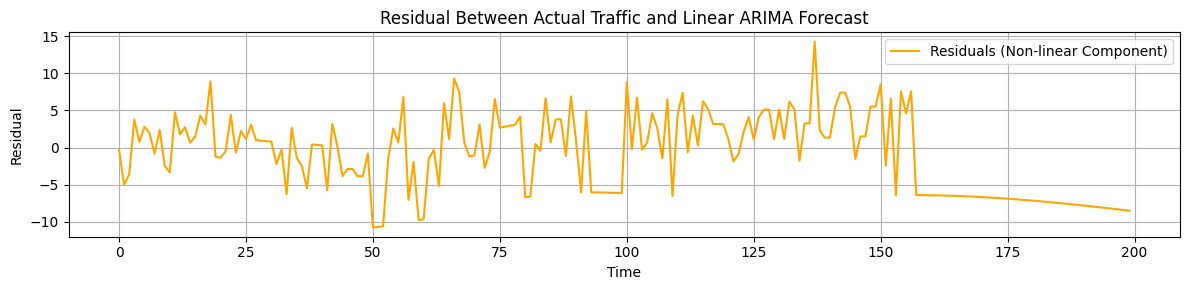

In [ ]:
# Get the actual traffic for the forecasted range
actual = signal[-n_forecast:]

# Compute residual = actual - linear forecast
residual = actual - linear_forecast

# Plot residuals
plt.figure(figsize=(12, 3))
plt.plot(residual, label='Residuals (Non-linear Component)', color='orange')
plt.title("Residual Between Actual Traffic and Linear ARIMA Forecast")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Prepare input-output pairs for supervised learning
X = []
y = []

window_size = 5  # how many previous residual points to use
for i in range(len(residual) - window_size):
    X.append(residual[i:i+window_size])
    y.append(residual[i+window_size])

X = np.array(X)
y = np.array(y)

# Normalize inputs
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (use all for training here since it's just residuals)
model_bpnn = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=1000, random_state=42)
model_bpnn.fit(X_scaled, y)

# Predict residuals
predicted_residuals = model_bpnn.predict(X_scaled)

# Pad to match forecast length
bpnn_forecast = np.concatenate([residual[:window_size], predicted_residuals])
bpnn_forecast = bpnn_forecast[:n_forecast]


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


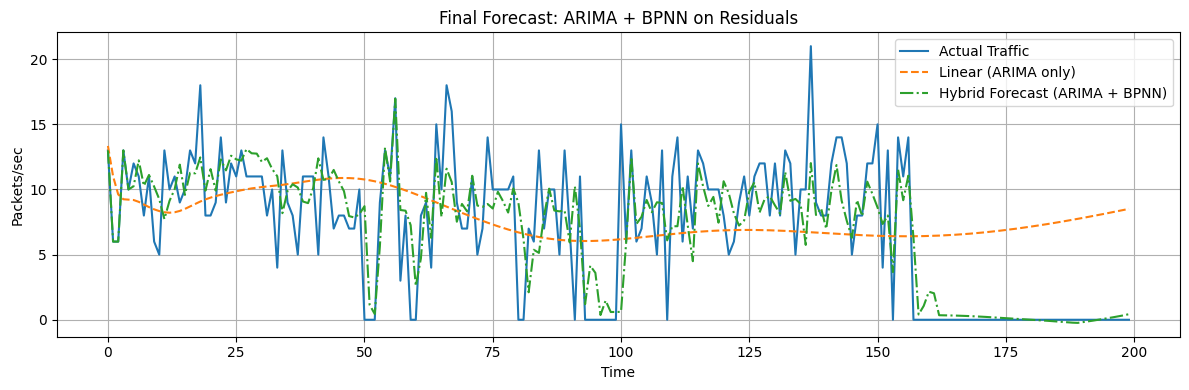

Hybrid Forecast MSE: 9.8135


In [ ]:
# Final forecast = linear part (ARIMA on IMFs) + non-linear part (BPNN on residuals)
final_forecast = linear_forecast + bpnn_forecast

# Plot everything
plt.figure(figsize=(12, 4))
plt.plot(actual, label='Actual Traffic')
plt.plot(linear_forecast, label='Linear (ARIMA only)', linestyle='--')
plt.plot(final_forecast, label='Hybrid Forecast (ARIMA + BPNN)', linestyle='-.')
plt.title("Final Forecast: ARIMA + BPNN on Residuals")
plt.xlabel("Time")
plt.ylabel("Packets/sec")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate
mse = mean_squared_error(actual, final_forecast)
print(f"Hybrid Forecast MSE: {mse:.4f}")


# ***NETWORK SCIENCE***

In [ ]:
!pip install pandas networkx matplotlib

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load CSV files
nodes_df = pd.read_csv("nodes.csv")
edges_df = pd.read_csv("edges.csv")

# Optional: limit to a sample of edges for faster plotting
edges_sample = edges_df.head(100)

# Build graph
G = nx.Graph()

# Add edges
for _, row in edges_sample.iterrows():
    G.add_edge(row["source"], row["target"])

# Add node attributes
for _, row in nodes_df.iterrows():
    node_id = row["node"]
    G.add_node(node_id, label=row["Label"], ntype=row["type"])

# Prepare labels (hide 'none' labels)
labels = {
    node: data['label'] if data.get('label', '') != 'none' else ''
    for node, data in G.nodes(data=True)
}

# Draw graph
plt.figure(figsize=(12, 9))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=False, node_color='skyblue', node_size=700, edge_color='gray')
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

plt.title("Sample Graph from edges.csv and nodes.csv")
plt.show()
